In [2032]:
from networkx import barabasi_albert_graph, draw
graph = barabasi_albert_graph(n=4, m=3, seed=42)

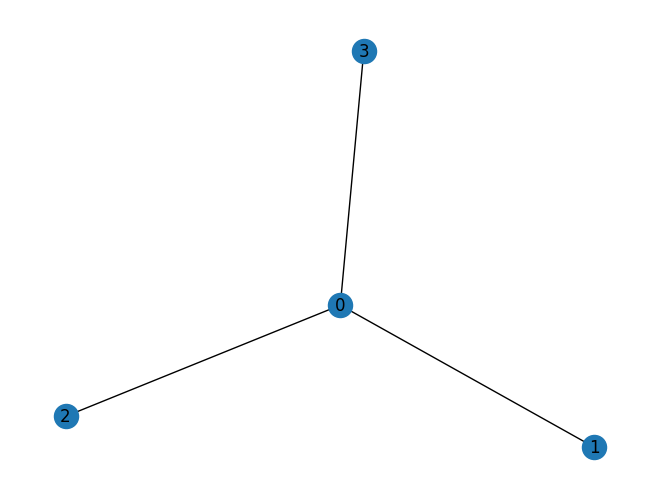

In [2033]:
draw(graph, with_labels=True)

In [2034]:
from qopt_best_practices.utils import build_max_cut_paulis
from qiskit.quantum_info import SparsePauliOp

local_correlators = build_max_cut_paulis(graph)
cost_operator = SparsePauliOp.from_list(local_correlators)
print(cost_operator)

SparsePauliOp(['IIZZ', 'IZIZ', 'ZIIZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j])


In [2035]:
num_qubits = cost_operator.num_qubits
print(num_qubits)

4


In [2036]:
qaoa_layers = 1

In [ ]:
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler import CouplingMap

cmap = CouplingMap.from_heavy_hex(distance=3)
print(cmap.size())
backend = GenericBackendV2(num_qubits = 4, basis_gates = ["x", "sx", "cz", "id", "rz"], seed=0)
print(backend.num_qubits)

19
7


In [2038]:
from qopt_best_practices.qubit_selection import BackendEvaluator
path_finder = BackendEvaluator(backend)
path, fidelity, num_subsets = path_finder.evaluate(num_qubits)
print(path, fidelity)

[0, 5, 1, 2] 0.9959109891448102


# 1. Standard Workflow

In [2039]:
from qiskit.circuit.library import qaoa_ansatz
qaoa_circuit = qaoa_ansatz(cost_operator, reps = qaoa_layers)

In [2040]:
qaoa_circuit.draw(fold=-1)

┌───┐                                                     ┌────────────┐
q_0: ┤ H ├─■────────────■──────────────────────────■───────────┤ Rx(2*β[0]) ├
     ├───┤ │ZZ(2*γ[0])  │           ┌────────────┐ │           └────────────┘
q_1: ┤ H ├─■────────────┼───────────┤ Rx(2*β[0]) ├─┼─────────────────────────
     ├───┤              │ZZ(2*γ[0]) ├────────────┤ │                         
q_2: ┤ H ├──────────────■───────────┤ Rx(2*β[0]) ├─┼─────────────────────────
     ├───┤                          └────────────┘ │ZZ(2*γ[0]) ┌────────────┐
q_3: ┤ H ├─────────────────────────────────────────■───────────┤ Rx(2*β[0]) ├
     └───┘                                                     └────────────┘

In [2041]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

naive_pm = generate_preset_pass_manager(backend=backend, optimization_level=3)

In [2042]:
import time

t0 = time.time()
naively_transpiled_qaoa = naive_pm.run(qaoa_circuit)
t1 = time.time()
print(f"transpilation time: {t1 - t0} (s)")
print(naively_transpiled_qaoa.count_ops())

transpilation time: 0.010078907012939453 (s)
OrderedDict([('rz', 19), ('sx', 12), ('cz', 6)])


In [2043]:
naively_transpiled_qaoa.draw(fold=-1)

global phase: π
                                      ┌─────────┐┌────┐┌───────┐┌────────────┐┌────┐   ┌────────────────┐   ┌────┐  ┌──────────┐                                                                                                                                                                     
q_1 -> 1 ───────────────────────────■─┤ Rz(π/2) ├┤ √X ├┤ Rz(π) ├┤ Rz(2*γ[0]) ├┤ √X ├─■─┤ Rz(π + 2*β[0]) ├───┤ √X ├──┤ Rz(5π/2) ├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
                                    │ └─────────┘└────┘└───────┘└────────────┘└────┘ │ └────────────────┘┌──┴────┴─┐└──┬────┬──┘┌───────┐┌────────────┐┌────┐   ┌────────────────┐   ┌────┐  ┌──────────┐                                                                                            
q_2 -> 2 ───────────────────────────┼────────────────────────────────────────────────┼─────────■─────────┤ Rz(π/2) ├───┤ √X ├───┤ Rz(π) ├┤ Rz(2*γ[0]) ├┤ √X ├─■─┤ Rz(π + 2*β[0]) ├───┤ √X ├──┤ Rz(5π/2) ├────────────────────────────────────────────────────────────────────────────────────────────
                                    │                                                │         │         └─────────┘   └────┘   └───────┘└────────────┘└────┘ │ └────────────────┘┌──┴────┴─┐└──┬────┬──┘┌───────┐┌────────────┐┌────┐   ┌────────────────┐      ┌────┐      ┌──────────┐            
q_3 -> 4 ───────────────────────────┼────────────────────────────────────────────────┼─────────┼──────────────────────────────────────────────────────────────┼─────────■─────────┤ Rz(π/2) ├───┤ √X ├───┤ Rz(π) ├┤ Rz(2*γ[0]) ├┤ √X ├─■─┤ Rz(π + 2*β[0]) ├──────┤ √X ├──────┤ Rz(5π/2) ├────────────
         ┌─────────┐┌────┐┌───────┐ │                                                │         │                                                              │         │         └─────────┘   └────┘   └───────┘└────────────┘└────┘ │ └─────┬────┬─────┘┌─────┴────┴─────┐└──┬────┬──┘┌──────────┐
q_0 -> 6 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π) ├─■────────────────────────────────────────────────■─────────■──────────────────────────────────────────────────────────────■─────────■──────────────────────────────────────────────────────────────■───────┤ √X ├──────┤ Rz(π + 2*β[0]) ├───┤ √X ├───┤ Rz(5π/2) ├
         └─────────┘└────┘└───────┘                                                                                                                                                                                                            └────┘      └────────────────┘   └────┘   └──────────┘

# 2. QOPT Workflow

In [2044]:
from qopt_best_practices.transpilation.cost_layer import get_cost_layer
cost_layer = get_cost_layer(cost_operator)
cost_layer.draw(fold=-1)

q_0: ─■────────────■────────────■───────────
      │ZZ(2*γ[0])  │            │           
q_1: ─■────────────┼────────────┼───────────
                   │ZZ(2*γ[0])  │           
q_2: ──────────────■────────────┼───────────
                                │ZZ(2*γ[0]) 
q_3: ───────────────────────────■───────────

In [2045]:
print(cost_layer.parameters)

ParameterView([ParameterVectorElement(γ[0])])


In [2046]:
from qiskit.transpiler.passes.routing.commuting_2q_gate_routing import (
    SwapStrategy,
    Commuting2qGateRouter,
)
from qiskit.transpiler import PassManager
from qopt_best_practices.transpilation.prepare_cost_layer import PrepareCostLayer
from qopt_best_practices.transpilation.swap_cancellation_pass import SwapToFinalMapping
from qiskit.circuit.library.standard_gates.equivalence_library import _sel
from qiskit.circuit.library import CXGate
from qiskit.transpiler.passes import (
    BasisTranslator,
    UnrollCustomDefinitions,
    HighLevelSynthesis,
    InverseCancellation
)

# 1. choose swap strategy (in this case -> line)
swap_strategy = SwapStrategy.from_line([i for i in range(num_qubits)])
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(num_qubits)}

# 2. define pass manager for cost layer
pre_init = PassManager(
    [
        PrepareCostLayer(),
        Commuting2qGateRouter(swap_strategy, edge_coloring),
        SwapToFinalMapping(),  # Removes unnecessary SWAP gates that the end of the block
        # HighLevelSynthesis(basis_gates=["x", "cx", "sx", "rz", "id"]),
        # InverseCancellation(gates_to_cancel=[CXGate()]),
    ]
)

In [2047]:
tmp = pre_init.run(cost_layer)
print(tmp.count_ops())
tmp.draw(fold=-1)

OrderedDict([('rzz', 3), ('swap', 3)])


q_0 -> 0 ─■────────────X──────────────────────────────
          │ZZ(2*γ[0])  │                              
q_1 -> 1 ─■────────────X──■────────────X──────────────
                          │ZZ(2*γ[0])  │              
q_2 -> 2 ──────X──────────■────────────X──■───────────
               │                          │ZZ(2*γ[0]) 
q_3 -> 3 ──────X──────────────────────────■───────────

In [2048]:
from qopt_best_practices.transpilation.qaoa_construction_pass import QAOAConstructionPass
init = PassManager([QAOAConstructionPass(num_layers=qaoa_layers)])

In [2049]:
tmp_out = init.run(tmp)
tmp_out.count_ops()
tmp_out.draw(fold=-1)

layout not found, assigining trivial layout


┌───┐                ┌────────────┐   ┌─┐                                     
q_0: ┤ H ├─■────────────X─┤ Rx(2*β[0]) ├───┤M├─────────────────────────────────────
     ├───┤ │ZZ(2*γ[0])  │ └────────────┘   └╥┘┌────────────┐              ┌─┐      
q_1: ┤ H ├─■────────────X──■─────────────X──╫─┤ Rx(2*β[0]) ├──────────────┤M├──────
     ├───┤                 │ZZ(2*γ[0])   │  ║ └────────────┘┌────────────┐└╥┘┌─┐   
q_2: ┤ H ├──────X──────────■─────────────X──╫──■────────────┤ Rx(2*β[0]) ├─╫─┤M├───
     ├───┤      │                           ║  │ZZ(2*γ[0])  ├────────────┤ ║ └╥┘┌─┐
q_3: ┤ H ├──────X───────────────────────────╫──■────────────┤ Rx(2*β[0]) ├─╫──╫─┤M├
     └───┘                                  ║               └────────────┘ ║  ║ └╥┘
c: 4/═══════════════════════════════════════╩══════════════════════════════╩══╩══╩═
                                            0                              1  2  3

In [2050]:
from qiskit.transpiler import Layout

# We use the obtained path to define the initial layout
initial_layout = Layout.from_intlist(path, cost_layer.qregs[0])

In [2051]:
staged_pm = generate_preset_pass_manager(3, backend, initial_layout=initial_layout)
staged_pm.pre_init = pre_init
staged_pm.init = init

In [2052]:
t0_opt = time.time()
optimally_transpiled_qaoa = staged_pm.run(cost_layer)
t1_opt = time.time()
print(f"transpilation time: {t1_opt - t0_opt} (s)")
print(optimally_transpiled_qaoa.count_ops())

transpilation time: 0.0022230148315429688 (s)
OrderedDict([('rz', 32), ('sx', 28), ('cz', 11), ('measure', 4)])


In [2053]:
optimally_transpiled_qaoa.draw(fold=-1)


global phase: 3π/2
         ┌─────────┐    ┌────┐   ┌────────────┐            ┌────┐                                                                    ┌────────┐  ┌────┐ ┌───────┐   ┌────┐  ┌─────────┐  ┌────────────────┐┌────┐┌──────────┐              ┌─┐                                                                                                                                                     
q_0 -> 0 ┤ Rz(π/2) ├────┤ √X ├───┤ Rz(2.8061) ├───────■────┤ √X ├──────────────────────────────────────────────────────────────────■─┤ Rz(-π) ├──┤ √X ├─┤ Rz(π) ├─■─┤ √X ├──┤ Rz(π/2) ├──┤ Rz(π + 2*β[0]) ├┤ √X ├┤ Rz(5π/2) ├──────────────┤M├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         └──┬────┬─┘┌───┴────┴──┐└────────────┘┌────┐ │    └────┘    ┌────┐                                   ┌───────┐            │ └────────┘  └────┘ └───────┘ │ └────┘  └─────────┘  └────────────────┘├────┤└┬────────┬┘┌────────────┐└╥┘   ┌────┐┌───────┐   ┌────┐                                                                 ┌────┐      ┌────────────────┐   ┌────┐   ┌──────────┐┌─┐
q_2 -> 1 ───┤ √X ├──┤ Rz(-3π/2) ├──────■───────┤ √X ├─┼──────■───────┤ √X ├──────────────────────────────■────┤ Rz(π) ├────────────┼──────────────────────────────┼──────────────────────────────■─────────┤ √X ├─┤ Rz(-π) ├─┤ Rz(2*γ[0]) ├─╫──■─┤ √X ├┤ Rz(π) ├─■─┤ √X ├────────■────────────────────────────────────────────────■───────┤ √X ├──────┤ Rz(π + 2*β[0]) ├───┤ √X ├───┤ Rz(5π/2) ├┤M├
         ┌──┴────┴─┐└───┬────┬──┘      │       ├────┤ │      │     ┌─┴────┴─┐   ┌────┐    ┌──────────┐   │    └─┬────┬┘  ┌───────┐ │                              │                              │         └────┘ └────────┘ └────────────┘ ║  │ └────┘└───────┘ │ └────┘        │         ┌────┐ ┌───────┐  ┌────────────┐┌────┐ │ ┌─────┴────┴─────┐└─────┬────┬─────┘┌──┴────┴──┐└───┬─┬────┘└╥┘
q_3 -> 2 ┤ Rz(π/2) ├────┤ √X ├─────────■───────┤ √X ├─┼──────■─────┤ Rz(-π) ├───┤ √X ├────┤ Rz(-π/2) ├───■──────┤ √X ├───┤ Rz(π) ├─┼──────────────────────────────┼──────────────────────────────┼──────────────────────────────────────────╫──┼─────────────────┼───────────────■─────────┤ √X ├─┤ Rz(π) ├──┤ Rz(2*γ[0]) ├┤ √X ├─■─┤ Rz(π + 2*β[0]) ├──────┤ √X ├──────┤ Rz(5π/2) ├────┤M├──────╫─
         └─────────┘    └────┘                 └────┘ │ ┌─────────┐└─┬────┬─┘┌──┴────┴──┐┌┴──────────┴┐┌────┐┌──┴────┴──┐└───────┘ │   ┌────┐  ┌───────┐          │ ┌────┐┌─────────────┐        │         ┌────┐ ┌────────┐                ║  │ ┌────┐┌───────┐ │ ┌────┐┌────────────────┐├────┤┌┴───────┴─┐└────┬─┬─────┘└────┘   └────────────────┘      └────┘      └──────────┘    └╥┘      ║ 
q_1 -> 5 ─────────────────────────────────────────────■─┤ Rz(π/2) ├──┤ √X ├──┤ Rz(-π/2) ├┤ Rz(2*γ[0]) ├┤ √X ├┤ Rz(-π/2) ├──────────■───┤ √X ├──┤ Rz(π) ├──────────■─┤ √X ├┤ Rz(0.33545) ├────────■─────────┤ √X ├─┤ Rz(-π) ├────────────────╫──■─┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(π + 2*β[0]) ├┤ √X ├┤ Rz(5π/2) ├─────┤M├────────────────────────────────────────────────────────────────────╫───────╫─
                                                        └─────────┘  └────┘  └──────────┘└────────────┘└────┘└──────────┘              └────┘  └───────┘            └────┘└─────────────┘                  └────┘ └────────┘                ║    └────┘└───────┘   └────┘└────────────────┘└────┘└──────────┘     └╥┘                                                                    ║       ║ 
    c: 4/═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════════╩══════════════════════════════════════════════════════════════════════╩═════════════════════════════════════════════════════════════════════╩═══════╩═
                                                                                                     

# 3. Annotated workflow

In [2054]:
from test_annotated_ansatz import annotated_qaoa_ansatz, AnnotatedPrepareCostLayer, AnnotatedCommuting2qGateRouter

In [2055]:
a_qaoa_circuit = annotated_qaoa_ansatz(cost_operator, reps = qaoa_layers)

AM I PRINTING
USE BOX
AM I PRINTING
USE BOX


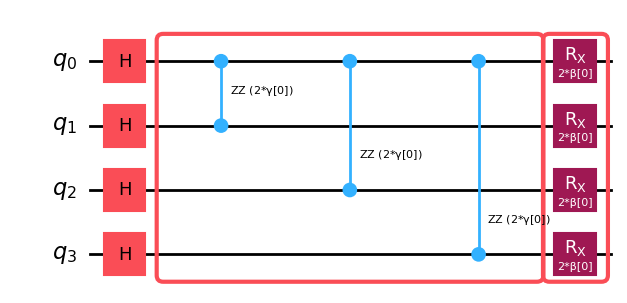

In [2056]:
a_qaoa_circuit.draw('mpl', fold=-1)

In [2057]:
swap_strategy = SwapStrategy.from_line([i for i in range(num_qubits)])
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(num_qubits)}

In [2058]:
pre_init = PassManager(
[
    AnnotatedPrepareCostLayer(),
    AnnotatedCommuting2qGateRouter(swap_strategy, edge_coloring),
    # SwapToFinalMapping(),  # Removes unnecessary SWAP gates that the end of the block
    # HighLevelSynthesis(basis_gates=["x", "cx", "sx", "rz", "id"]),
    # InverseCancellation(gates_to_cancel=[CXGate()]),
]
)

In [2059]:
tmp = pre_init.run(a_qaoa_circuit)
print(tmp.count_ops())
tmp.draw(fold=-1)

GATE LAYERS defaultdict(<class 'dict'>, {np.int64(0): {(0, 1): Instruction(name='rzz', num_qubits=2, num_clbits=0, params=[<qiskit._accelerate.circuit.ParameterExpression object at 0x13c193a50>])}, np.int64(2): {(0, 2): Instruction(name='rzz', num_qubits=2, num_clbits=0, params=[<qiskit._accelerate.circuit.ParameterExpression object at 0x13d5eaa90>])}, np.int64(1): {(0, 3): Instruction(name='rzz', num_qubits=2, num_clbits=0, params=[<qiskit._accelerate.circuit.ParameterExpression object at 0x13d5eabb0>])}})
OrderedDict([('h', 4), ('rx', 4), ('rzz', 3), ('swap', 3)])


┌───┐                ┌────────────┐                               
q_0 -> 0 ┤ H ├─■────────────X─┤ Rx(2*β[0]) ├───────────────────────────────
         ├───┤ │ZZ(2*γ[0])  │ └────────────┘   ┌────────────┐              
q_1 -> 1 ┤ H ├─■────────────X──■─────────────X─┤ Rx(2*β[0]) ├──────────────
         ├───┤                 │ZZ(2*γ[0])   │ └────────────┘┌────────────┐
q_2 -> 2 ┤ H ├──────X──────────■─────────────X──■────────────┤ Rx(2*β[0]) ├
         ├───┤      │                           │ZZ(2*γ[0])  ├────────────┤
q_3 -> 3 ┤ H ├──────X───────────────────────────■────────────┤ Rx(2*β[0]) ├
         └───┘                                               └────────────┘

In [2060]:
annotated_pm = generate_preset_pass_manager(3, backend, initial_layout=initial_layout)
annotated_pm.pre_init = pre_init
t0_opt = time.time()
optimally_transpiled_qaoa = annotated_pm.run(cost_layer)
t1_opt = time.time()
print(f"transpilation time: {t1_opt - t0_opt} (s)")
print(optimally_transpiled_qaoa.count_ops())

transpilation time: 0.0009710788726806641 (s)
OrderedDict([('rz', 18), ('sx', 12), ('cz', 6)])


In [2061]:
optimally_transpiled_qaoa.draw(fold=-1)

global phase: π
                                                                                                                                                                                                                    
q_0 -> 0 ───────────────────────────■──────────────────────────────────────────────■───■─────────────────────────────────────────────────────■──■────────────────────────────────────────────────■──────────────────
         ┌─────────┐┌────┐┌───────┐ │                                              │   │      ┌────┐  ┌───────┐┌────────────┐┌────┐┌───────┐ │  │ ┌────┐┌─────────┐                              │                  
q_2 -> 1 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π) ├─┼──────────────────────────────────────────────┼───■──────┤ √X ├──┤ Rz(π) ├┤ Rz(2*γ[0]) ├┤ √X ├┤ Rz(π) ├─■──┼─┤ √X ├┤ Rz(π/2) ├──────────────────────────────┼──────────────────
         ├─────────┤├────┤├───────┤ │                                              │          └────┘  └───────┘└────────────┘└────┘└───────┘    │ ├────┤└┬───────┬┘┌────────────┐┌────┐┌───────┐ │ ┌────┐┌─────────┐
q_3 -> 2 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π) ├─┼──────────────────────────────────────────────┼────────────────────────────────────────────────────────────■─┤ √X ├─┤ Rz(π) ├─┤ Rz(2*γ[0]) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(π/2) ├
         ├─────────┤├────┤├───────┤ │ ┌────┐┌───────┐┌────────────┐┌────┐┌───────┐ │ ┌────┐┌─────────┐                                            └────┘ └───────┘ └────────────┘└────┘└───────┘   └────┘└─────────┘
q_1 -> 5 ┤ Rz(π/2) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(π) ├┤ Rz(2*γ[0]) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├┤ Rz(π/2) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────
         └─────────┘└────┘└───────┘   └────┘└───────┘└────────────┘└────┘└───────┘   └────┘└─────────┘

# 4. Confirmation using sampler

In [2062]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt


def generate_demo_graph():
    # Generating a graph of 5 nodes
    n = 7  # Number of nodes in graph
    G = nx.Graph()
    G.add_nodes_from(np.arange(0, n, 1))
    elist = [(0, 1, 1.0), (0, 2, 1.0), (0, 4, 1.0), (1, 2, 1.0), (2, 3, 1.0), (3, 4, 1.0), (3,5, 1.0), (5,2, 1.0), (5,6, 1.0)]
    # tuple is (i,j,weight) where (i,j) is the edge
    G.add_weighted_edges_from(elist)
    return G

def draw_graph(G):
    colors = ["tab:grey" for node in G.nodes()]
    pos = nx.spring_layout(G)
    default_axes = plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, ax=default_axes, pos=pos)
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


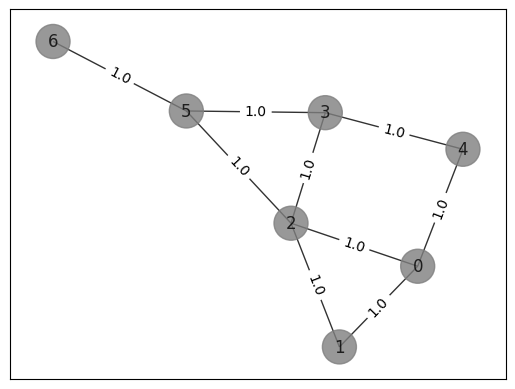

In [2063]:
demo_graph = generate_demo_graph()

draw_graph(demo_graph)

In [2064]:
from qiskit_optimization.applications import Maxcut
from qiskit.circuit.library import QAOAAnsatz


def map_graph_to_qubo(graph):
    max_cut = Maxcut(graph)
    qp = max_cut.to_quadratic_program()
    return qp


def map_qubo_to_ising(qubo):
    qubitOp, offset = qubo.to_ising()
    return qubitOp, offset


def map_ising_to_circuit(hamiltonian, num_layers):
    ansatz = QAOAAnsatz(cost_operator=hamiltonian, reps=num_layers)
    ansatz.measure_all()
    return ansatz

In [2065]:
qubo = map_graph_to_qubo(demo_graph)
print(qubo.prettyprint())

Problem name: Max-cut

Maximize
  -2*x_0*x_1 - 2*x_0*x_2 - 2*x_0*x_4 - 2*x_1*x_2 - 2*x_2*x_3 - 2*x_2*x_5
  - 2*x_3*x_4 - 2*x_3*x_5 - 2*x_5*x_6 + 3*x_0 + 2*x_1 + 4*x_2 + 3*x_3 + 2*x_4
  + 3*x_5 + x_6

Subject to
  No constraints

  Binary variables (7)
    x_0 x_1 x_2 x_3 x_4 x_5 x_6



In [2066]:
cost_hamiltonian, offset = map_qubo_to_ising(qubo)
print("Cost Function Hamiltonian:", cost_hamiltonian)

Cost Function Hamiltonian: SparsePauliOp(['IIIIIZZ', 'IIIIZIZ', 'IIZIIIZ', 'IIIIZZI', 'IIIZZII', 'IZIIZII', 'IIZZIII', 'IZIZIII', 'ZZIIIII'],
              coeffs=[0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j, 0.5+0.j,
 0.5+0.j])


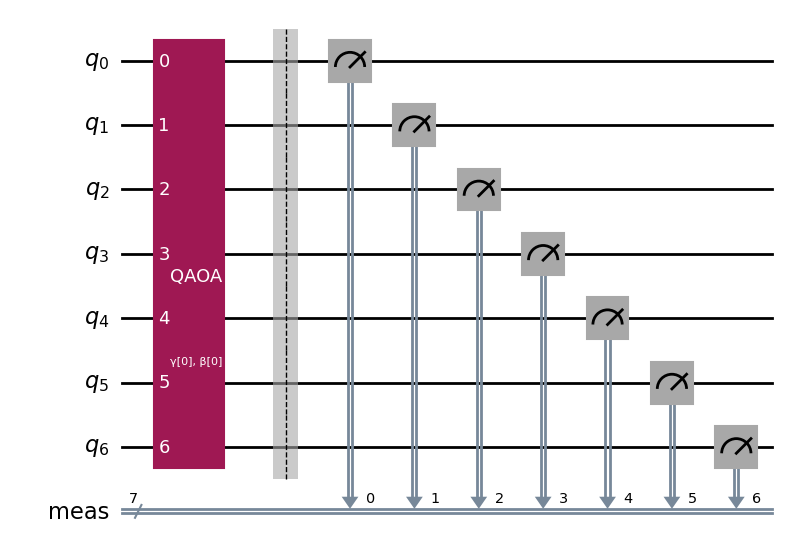

In [2067]:
circuit = map_ising_to_circuit(cost_hamiltonian, num_layers=1)
circuit.draw('mpl')

In [2068]:
from qiskit_ibm_runtime.fake_provider import FakeVigoV2
from qiskit.primitives import BackendSamplerV2

def run_sampler(isa_circuit):
    optimal_gamma = 5.11350346
    optimal_beta = 5.52673212

    candidate_circuit = isa_circuit.assign_parameters([optimal_gamma, optimal_beta])
    # backend = FakeVigoV2()
    backend = GenericBackendV2(num_qubits=7)
    sampler = BackendSamplerV2(backend=backend)
    final_distribution = sampler.run([candidate_circuit], shots=int(1e4)).result()[0].data.meas.get_counts()
    return final_distribution


In [2069]:
import numpy as np

# auxiliary functions to sample most likely bitstring
def to_bitstring(integer, num_bits):
    result = np.binary_repr(integer, width=num_bits)
    return [int(digit) for digit in result]


def sample_most_likely(state_vector, num_bits):
    keys = list(state_vector.keys())
    values = list(state_vector.values())
    most_likely = keys[np.argmax(np.abs(values))]
    most_likely_bitstring = [int(bit) for bit in most_likely]
    # most_likely_bitstring = to_bitstring(most_likely, num_bits)
    most_likely_bitstring.reverse()
    return np.asarray(most_likely_bitstring)


In [2070]:
import matplotlib
import matplotlib.pyplot as plt

def plot_distribution(final_distribution):
    matplotlib.rcParams.update({"font.size": 10})
    final_bits = final_distribution
    values = np.abs(list(final_bits.values()))
    top_4_values = sorted(values, reverse=True)[:4]
    positions = []
    for value in top_4_values:
        positions.append(np.where(values == value)[0])
    fig = plt.figure(figsize=(11, 6))
    ax = fig.add_subplot(1, 1, 1)
    plt.xticks(rotation=45)
    plt.title("Result Distribution")
    plt.xlabel("Bitstrings (reversed)")
    plt.ylabel("Probability")
    ax.bar(list(final_bits.keys()), list(final_bits.values()), color="tab:grey")
    for p in positions:
        ax.get_children()[int(p)].set_color("tab:purple")
    plt.show()

In [2071]:
# auxiliary function to plot graphs
def plot_result(G, x):
    colors = ["tab:grey" if i == 0 else "tab:purple" for i in x]
    pos, default_axes = nx.spring_layout(G), plt.axes(frameon=True)
    nx.draw_networkx(G, node_color=colors, node_size=600, alpha=0.8, pos=pos)

# NAIVE

In [2072]:
circuit_naive = naive_pm.run(circuit)
circuit_naive.draw(fold=-1)

global phase: 7π/4
                                                                                                                                                                                                                                                                          ┌─────────┐    ┌────┐   ┌───────┐┌──────────┐┌────┐┌───────┐   ┌────┐ ┌───────┐                                                                                                                                        ┌────┐┌────────────────┐┌────┐┌──────────┐                                                                                                 ░          ┌─┐         
q_3 -> 0 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────■─────────┤ Rz(π/2) ├────┤ √X ├───┤ Rz(π) ├┤ Rz(γ[0]) ├┤ √X ├┤ Rz(π) ├─■─┤ √X ├─┤ Rz(π) ├───■─────────────────────────────────────────────────■────────────────────■───────────────────────────────────────────────────────────■─┤ √X ├┤ Rz(π + 2*β[0]) ├┤ √X ├┤ Rz(5π/2) ├─────────────────────────────────────────────────────────────────────────────────────────────────░──────────┤M├─────────
                                                                                                                                                                                                                                                                │         └─────────┘    └────┘   └───────┘└──────────┘└────┘└───────┘ │ └────┘ └───────┘   │                                                 │                    │                                                           │ └────┘└────────────────┘└────┘├─────────┬┘┌────┐┌───────┐┌──────────┐┌────┐   ┌────────────────┐      ┌────┐      ┌──────────┐             ░          └╥┘      ┌─┐
q_6 -> 1 ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────────────┼────────────────────┼─────────────────────────────────────────────────┼────────────────────┼───────────────────────────────────────────────────────────┼───────────────────────────■───┤ Rz(π/2) ├─┤ √X ├┤ Rz(π) ├┤ Rz(γ[0]) ├┤ √X ├─■─┤ Rz(π + 2*β[0]) ├──────┤ √X ├──────┤ Rz(5π/2) ├─────────────░───────────╫───────┤M├
                                                                                                       ┌─────────┐┌────┐┌───────┐┌──────────┐┌────┐┌───────┐         ┌────┐  ┌───────┐┌──────────┐   ┌────┐   ┌───────┐         ┌────┐    ┌───────┐             │                                                                      │                    │                                                 │       ┌────┐       │ ┌────────────────┐   ┌────┐   ┌──────────┐                │                           │   └─────────┘ └────┘└───────┘└──────────┘└────┘ │ └────────────────┘      └────┘      └──────────┘             ░       ┌─┐ ║       └╥┘
q_2 -> 2 ────────────────────────────────────────────────────────────────────────────────────────────■─┤ Rz(π/2) ├┤ √X ├┤ Rz(π) ├┤ Rz(γ[0]) ├┤ √X ├┤ Rz(π) ├─■──■────┤ √X ├──┤ Rz(π) ├┤ Rz(γ[0]) ├───┤ √X ├───┤ Rz(π) ├────■────┤ √X ├────┤ Rz(π) ├─────────────■──────────────────────────────────────────────────────────────────────■───■────────────────┼──────────────────────────────────────────────■──┼───────┤ √X ├───────┼─┤ Rz(π + 2*β[0]) ├───┤ √X ├───┤ Rz(5π/2) ├────────────────┼───────────────────────────┼─────────────────────────────────────────────────┼──────────────────────────────────────────────────────────────░───────┤M├─╫────────╫─
                                      ┌─────────┐┌────┐┌───────┐┌──────────┐┌────┐┌───────┐   ┌────┐ │ └┬───────┬┘└──

In [2073]:
circuit_naive.data

[CircuitInstruction(operation=Instruction(name='rz', num_qubits=1, num_clbits=0, params=[1.5707963267948966]), qubits=(<Qubit register=(7, "q"), index=6>,), clbits=()), CircuitInstruction(operation=Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]), qubits=(<Qubit register=(7, "q"), index=6>,), clbits=()), CircuitInstruction(operation=Instruction(name='rz', num_qubits=1, num_clbits=0, params=[3.141592653589793]), qubits=(<Qubit register=(7, "q"), index=6>,), clbits=()), CircuitInstruction(operation=Instruction(name='cz', num_qubits=2, num_clbits=0, params=[]), qubits=(<Qubit register=(7, "q"), index=6>, <Qubit register=(7, "q"), index=3>), clbits=()), CircuitInstruction(operation=Instruction(name='rz', num_qubits=1, num_clbits=0, params=[1.5707963267948966]), qubits=(<Qubit register=(7, "q"), index=3>,), clbits=()), CircuitInstruction(operation=Instruction(name='sx', num_qubits=1, num_clbits=0, params=[]), qubits=(<Qubit register=(7, "q"), index=3>,), clbits=()), CircuitInst

In [2074]:
out_naive = run_sampler(circuit_naive)
print(out_naive)


{'0001001': 53, '0011110': 53, '0101001': 391, '0110100': 377, '1110011': 65, '1001001': 316, '0110010': 419, '1011001': 62, '1100001': 54, '1000111': 27, '1110110': 76, '0101011': 421, '0001100': 99, '0010111': 3, '0011100': 57, '1010011': 64, '1000101': 173, '1010100': 418, '1001011': 386, '0100100': 27, '0001101': 165, '1010000': 65, '1011111': 34, '0110011': 122, '0001011': 53, '0110110': 288, '1011101': 31, '1110100': 49, '0101010': 166, '0100001': 164, '0101100': 69, '0000001': 61, '0100101': 257, '1111110': 43, '0001010': 56, '1001110': 203, '1011110': 150, '0111101': 47, '1101010': 28, '0100110': 77, '1011010': 244, '1011011': 38, '0111110': 31, '1100110': 15, '0100011': 111, '1110010': 186, '0110101': 127, '1010101': 163, '1001101': 408, '0010001': 6, '0110001': 188, '0010110': 63, '1001100': 139, '1101011': 107, '1111011': 31, '1010110': 353, '0000100': 24, '0011010': 59, '0010101': 21, '0111010': 185, '1011100': 99, '0100010': 22, '1110101': 51, '1001010': 152, '0001110': 94

/Users/ept/qiskit_workspace/qopt-best-practices/.venv/lib/python3.11/site-packages/qiskit/providers/fake_provider/generic_backend_v2.py:348: RuntimeWarning: Aer not found using BasicSimulator and no noise
  warnings.warn("Aer not found using BasicSimulator and no noise", RuntimeWarning)


In [2075]:
best_result = sample_most_likely(out_naive, len(demo_graph))
print("Result bitstring:", best_result)

Result bitstring: [1 1 0 1 0 1 0]


/var/folders/cp/vp6kmzjd68qg5zjvwyls05000000gn/T/ipykernel_84630/1961673510.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


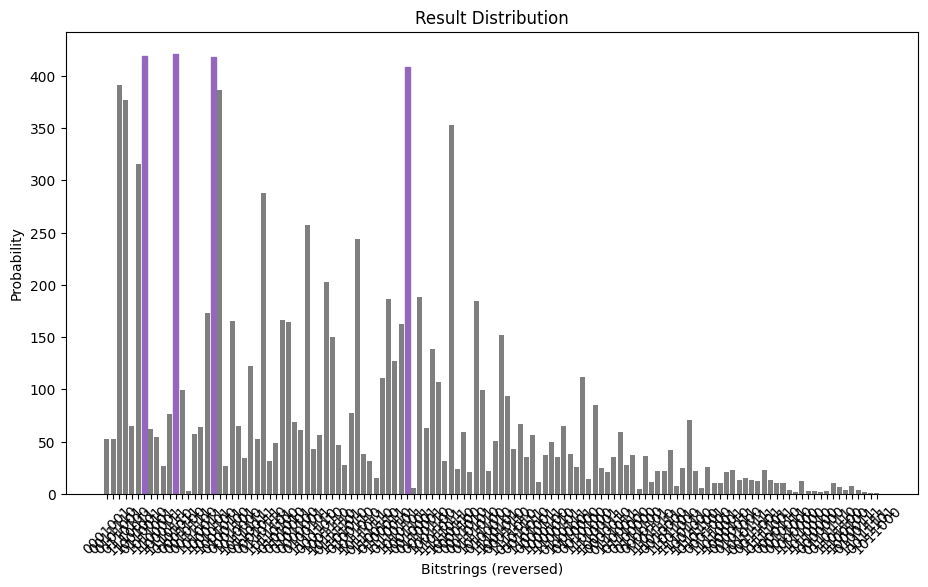

In [2076]:
plot_distribution(out_naive)

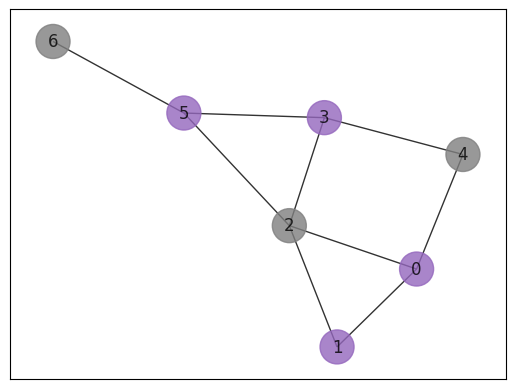

In [2077]:
plot_result(demo_graph, best_result)

# 2. ANNOTATED

In [2078]:
circuit_annotated = annotated_pm.run(circuit)
circuit_annotated.draw(fold=-1)

TranspilerError: 'FullAncillaAllocation: The layout refers to a qubit that does not exist in circuit.'

In [ ]:
out_annotated = run_sampler(circuit_annotated)
print(out_annotated)

{'1010000': 63, '0101011': 415, '1011010': 250, '0110010': 407, '0110100': 426, '1001110': 199, '1110001': 99, '0101010': 177, '1001010': 124, '0100101': 261, '1010100': 410, '0011100': 62, '1011001': 76, '0010110': 50, '1110011': 98, '0110011': 124, '0000101': 44, '0110111': 79, '1101010': 23, '1011100': 99, '1110110': 71, '0100110': 60, '1001011': 390, '1000111': 52, '1010101': 159, '0100001': 145, '0101001': 351, '1100011': 64, '0110101': 120, '1001100': 126, '0111011': 40, '1101011': 112, '1001001': 344, '1001101': 453, '1110010': 184, '1011110': 134, '0111010': 183, '0111000': 43, '1000101': 209, '0000001': 55, '1110111': 22, '0001101': 159, '0001011': 39, '0011101': 3, '0111101': 51, '0010100': 103, '1010110': 339, '0110110': 311, '0001010': 47, '1000100': 47, '1010011': 82, '0100011': 92, '0010010': 41, '0010000': 21, '0111110': 26, '1000010': 38, '0100010': 22, '1011111': 47, '1101000': 10, '1100110': 18, '1011011': 28, '0011010': 43, '0100000': 31, '1100001': 31, '1101001': 58

In [ ]:
best_result = sample_most_likely(out_annotated, len(demo_graph))
print("Result bitstring:", best_result)

Result bitstring: [1 0 1 1 0 0 1]


/var/folders/cp/vp6kmzjd68qg5zjvwyls05000000gn/T/ipykernel_84630/1961673510.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


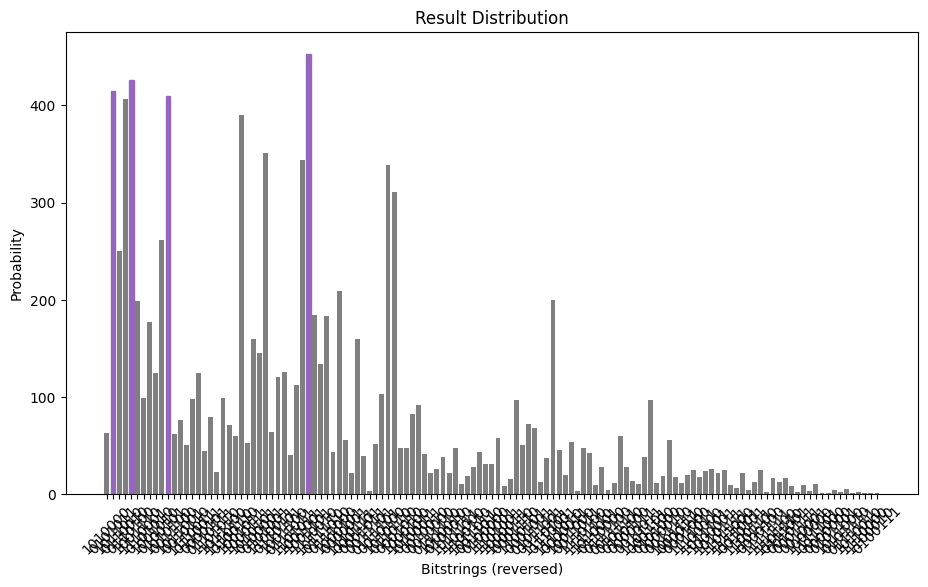

In [ ]:
plot_distribution(out_annotated)

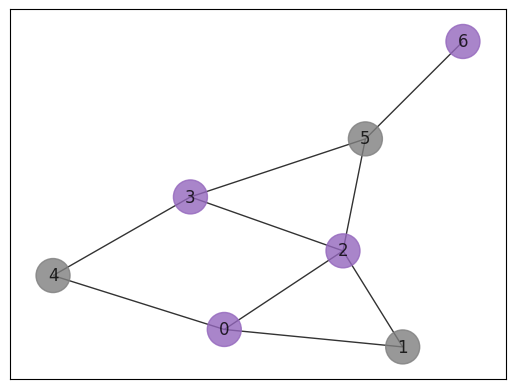

In [ ]:
plot_result(demo_graph, best_result)

# 3. QOPT

In [ ]:
cost_layer = get_cost_layer(cost_hamiltonian)


In [ ]:
initial_layout = Layout.from_intlist(path, cost_layer.qregs[0])

In [ ]:
swap_strategy = SwapStrategy.from_line([i for i in range(num_qubits)])
edge_coloring = {(idx, idx + 1): (idx + 1) % 2 for idx in range(num_qubits)}

# 2. define pass manager for cost layer
pre_init = PassManager(
    [
        PrepareCostLayer(),
        Commuting2qGateRouter(swap_strategy, edge_coloring),
        SwapToFinalMapping(),  # Removes unnecessary SWAP gates that the end of the block
        HighLevelSynthesis(basis_gates=["x", "cx", "sx", "rz", "id"]),
        InverseCancellation(gates_to_cancel=[CXGate()]),
    ]
)

In [ ]:
init = PassManager([QAOAConstructionPass(num_layers=qaoa_layers)])

In [ ]:
staged_pm = generate_preset_pass_manager(3, backend, initial_layout=initial_layout)
staged_pm.pre_init = pre_init
staged_pm.init = init

In [ ]:
circuit_qopt = staged_pm.run(cost_layer)

circuit_qopt.draw(fold=-1)
circuit_qopt.remove_final_measurements()
circuit_qopt.measure_all()

/Users/ept/qiskit_workspace/qopt-best-practices/.venv/lib/python3.11/site-packages/qiskit/circuit/quantumcircuit.py:4625: UserWarning: Trying to add QuantumRegister to a QuantumCircuit having a layout
  circ.add_register(qreg)


In [ ]:
out_qopt= run_sampler(circuit_qopt)
print(out_qopt)


{'1001100': 208, '0111111': 39, '0011010': 445, '1000100': 177, '1101000': 390, '1101001': 189, '0101011': 40, '0010001': 92, '0000011': 62, '1000101': 360, '1010000': 11, '0000101': 84, '0110001': 119, '0111100': 76, '0010101': 333, '1101010': 296, '0010011': 126, '0110101': 394, '0000100': 57, '1001110': 111, '0011000': 77, '1001010': 381, '1100001': 175, '1000011': 64, '0010111': 408, '0001010': 103, '0011101': 68, '1011110': 43, '1110101': 102, '0111010': 364, '0000111': 146, '0010110': 191, '1001000': 26, '0011110': 192, '1110001': 26, '1000110': 248, '0110011': 210, '1010101': 73, '1011010': 51, '0111101': 26, '1100101': 384, '1101110': 80, '1100100': 92, '1111100': 101, '0100001': 46, '1110111': 19, '1011100': 106, '0110110': 32, '0100011': 89, '0111011': 148, '0110010': 11, '1100111': 63, '0101111': 13, '1010100': 46, '0101010': 66, '0011011': 104, '1111001': 44, '1010110': 53, '0111001': 247, '1110100': 61, '1010111': 53, '1111111': 5, '0010010': 36, '0000001': 18, '0110000': 

In [ ]:
best_result = sample_most_likely(out_qopt, len(demo_graph))
print("Result bitstring:", best_result)

Result bitstring: [0 1 0 1 1 0 0]


/var/folders/cp/vp6kmzjd68qg5zjvwyls05000000gn/T/ipykernel_84630/1961673510.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  ax.get_children()[int(p)].set_color("tab:purple")


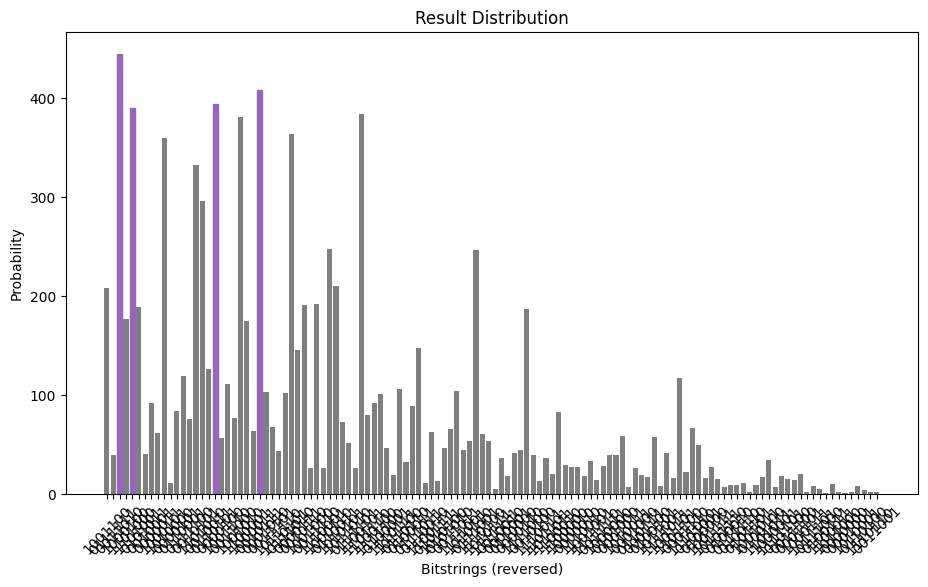

In [ ]:
plot_distribution(out_qopt)

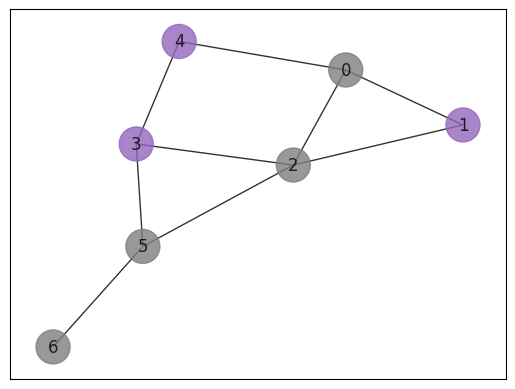

In [ ]:
plot_result(demo_graph, best_result)

# EXPECTATION VALUE COMPARISON

In [ ]:
from qiskit.primitives import StatevectorEstimator

estimator = StatevectorEstimator()
optimal_gamma = 5.11350346
optimal_beta = 5.52673212

In [ ]:
circuit_annotated = annotated_pm.run(circuit)
print(circuit_annotated.parameters)
circuit_annotated.draw(fold=-1)
circuit_annotated.remove_final_measurements()
out_naive = estimator.run([(circuit_annotated, cost_hamiltonian, [optimal_gamma, optimal_beta])]).result()[0].data.values()
out_naive

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(γ[0])])


dict_values([array(-0.49665931), array(0.)])

In [ ]:
circuit_naive = naive_pm.run(circuit)
print(circuit_naive.parameters)
circuit_naive.draw(fold=-1)
circuit_naive.remove_final_measurements()
out_naive = estimator.run([(circuit_naive, cost_hamiltonian, [optimal_gamma, optimal_beta])]).result()[0].data.values()
out_naive

ParameterView([ParameterVectorElement(β[0]), ParameterVectorElement(γ[0])])


dict_values([array(-0.30493411), array(0.)])

In [ ]:
circuit_qopt.remove_final_measurements()
out_qopt = estimator.run([(circuit_qopt, cost_hamiltonian, [optimal_gamma, optimal_beta])]).result()[0].data.values()
out_qopt

dict_values([array(-0.31829783), array(0.)])